In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats

#Задание по продуктовой аналитике

 Найти точку роста бизнеса и сформулировать гипотезу улучшение бизнес процесса для роста метрик и
опишите их механику тестирования с учетом того что тест не должен занимать больше 2-х недель.
 1. Посчитать юнит-экономику по продуктам.
 2. Из юнит-экономики определить точки роста бизнеса.
 3. Понять дерево метрик для бизнеса.
 4. Понять на какую метрику продукта они будут воздействовать и сформировать гипотезы.
 5. Описать метод проверки гипотез с формулированием условия проведения гипотезы.


## 1. Посчитать юнит-экономику по продуктам (расчет метрик).
* UA (Users) - количество лидов (юнитов масштабирования)
* B (Bayers) - количество клиентов
* C1 (Conversion Rate) = B / UA = конверсия
* AC (Marketing Budget) - маркетинговый бюджет
* CPA (Cost Per Acquisition) = AC / UA = стоимость привлечения одного UA
* CAC (Customer Acquisition Cost) = AC / B = стоимость привлечения одного B
* Gross Revenue (Total Sales) - выручка общая
* AOV (Average Order Value) = Gross Revenue / B = средний чек
* APC (Average Purchases per Customer) - среднее число сделок на одного B
* CLTV (Customer Lifetime Value) = AOV × APC = средняя валовая прибыль на одного В (нет данных для расчета COGS и 1sCOGS)
* LTV (Lifetime Value) = Gross Revenue / UA = средняя валовая прибыль на одного UA
* CM (Contribution Margin) = (CLTV – CAC) × B = маржинальная прибыль
* Total Deals (Total successful of deals) - количество успешных сделок

In [2]:
deals = pd.read_excel("Deals (Result).xlsx")
spend = pd.read_excel("Spend (Result).xlsx")

In [3]:
deals.head()

,Id,Deal Owner Name,Closing Date,Quality,Stage,Lost Reason,Page,Campaign,Content,Term,...,Education Type,Created Time,Course duration,Months of study,Initial Amount Paid,Offer Total Amount,Contact Name,City,Level of Deutsch,SLA Seconds
0,5805028000056864695,Ben Hall,NaT,NaN,New Lead,NaN,/eng/test,03.07.23women,v16,women,...,NaN,2024-06-21 15:30:00,NaN,NaN,NaN,NaN,5805028000056849495,NaN,Unknown,NaN
1,5805028000056859489,Ulysses Adams,NaT,NaN,New Lead,NaN,/at-eng,NaN,NaN,NaN,...,Morning,2024-06-21 15:23:00,6.0,NaN,0.0,2000.0,5805028000056834471,NaN,Unknown,NaN
2,5805028000056832357,Ulysses Adams,2024-06-21,D - Non Target,Lost,Non target,/at-eng,engwien_AT,b1-at,21_06_2024,...,NaN,2024-06-21 14:45:00,NaN,NaN,NaN,NaN,5805028000056854421,NaN,Unknown,1603.0
3,5805028000056824246,Eva Kent,2024-06-21,E - Non Qualified,Lost,Invalid number,/eng,04.07.23recentlymoved_DE,bloggersvideo14com,recentlymoved,...,NaN,2024-06-21 13:32:00,NaN,NaN,NaN,NaN,5805028000056889351,NaN,Unknown,3604.0
4,5805028000056873292,Ben Hall,2024-06-21,D - Non Target,Lost,Non target,/eng,discovery_DE,website,NaN,...,NaN,2024-06-21 13:21:00,NaN,NaN,NaN,NaN,5805028000056876176,NaN,Unknown,3192.0


In [4]:
spend.head()

,Date,Source,Campaign,Impressions,Spend,Clicks,AdGroup,Ad
0,2023-07-03,Google Ads,gen_analyst_DE,6,0.00,0,NaN,NaN
1,2023-07-03,Google Ads,performancemax_eng_DE,4,0.01,1,NaN,NaN
2,2023-07-03,Facebook Ads,03.07.23women,187,3.30,6,women,b3
3,2023-07-03,Facebook Ads,03.07.23women,4,0.02,1,women,b1
4,2023-07-03,Facebook Ads,02.07.23wide_DE,61,0.58,0,wide,b4


Посчитаем метрики для каждого продукта

In [5]:
pd.set_option('display.float_format', '{:,.2f}'.format)

# UA (Users) - количество лидов (юнитов масштабирования)
users = deals.groupby(['Product', 'Education Type'],
                      observed=True)['Id'].nunique().rename('UA')

# B (Bayers) - количество клиентов
bayers = deals[deals['Stage'] == 'Payment Done']\
        .groupby(['Product', 'Education Type'], observed=True
          )['Id'].nunique().rename('Bayers')

# Total Deals (Total successful deals) - количество успешных сделок
total_deals = deals[deals['Stage'] == 'Payment Done']\
        .groupby(['Product', 'Education Type'],
         observed=True)['Id'].count().rename('Total Deals')

# Gross Revenue (Total Sales) - выручка общая
gross_revenue = deals[deals['Stage'] == 'Payment Done']\
         .groupby(['Product', 'Education Type'],
         observed=True)['Offer Total Amount'].sum().rename('Gross Revenue')

merged_df = users.to_frame().join(
    [bayers, total_deals, gross_revenue], how='left').reset_index()

# AC (Marketing Budget) - общий маркетинговый бюджет для всех продуктов
total_ac = spend['Spend'].sum()

merged_df['C1'] = merged_df['Bayers'] / merged_df['UA']
merged_df['AC'] = total_ac
merged_df['CPA'] = merged_df['AC'] / merged_df['UA']
merged_df['CAC'] = merged_df['AC'] / merged_df['Bayers']
merged_df['AOV'] = merged_df['Gross Revenue'] / merged_df['Bayers']
merged_df['APC'] = merged_df['Total Deals'] / merged_df['Bayers']
merged_df['CLTV'] = merged_df['AOV'] * merged_df['APC']
merged_df['LTV'] = merged_df['Gross Revenue'] / merged_df['UA']
merged_df['CM'] = (merged_df['CLTV'] - merged_df['CAC']) * merged_df['Bayers']

merged_df_sorted = merged_df.sort_values(by='Bayers', ascending=False)

merged_df_sorted = merged_df_sorted[['Product', 'Education Type', 'UA',
                                     'Bayers', 'C1', 'AC', 'CPA', 'CAC',
                                     'Gross Revenue', 'AOV', 'APC', 'CLTV',
                                     'LTV', 'CM', 'Total Deals']]

def format_number(value):
    return f'{value:,.0f}'.replace(',', ' ')

formatted_product_education_performance = merged_df_sorted.style.format({
    'UA': format_number,
    'Bayers': format_number,
    'Gross Revenue': format_number,
    'AC': format_number,
    'APC': '{:,.2f}'.format,
    'CAC': format_number,
    'CPA': format_number,
    'AOV': format_number,
    'CLTV': format_number,
    'LTV': format_number,
    'CM': format_number,
    'C1': '{:.2%}'.format,
    'Total Deals': format_number
}).hide(axis='index')

display(formatted_product_education_performance)

Product,Education Type,UA,Bayers,C1,AC,CPA,CAC,Gross Revenue,AOV,APC,CLTV,LTV,CM,Total Deals
Digital Marketing,Morning,1 618,361,22.31%,149 232,92,413,3 522 200,9 757,1.00,9 757,2 177,3 372 968,361
UX/UI Design,Morning,815,170,20.86%,149 232,183,878,1 608 400,9 461,1.00,9 461,1 973,1 459 168,170
Web Developer,Morning,542,137,25.28%,149 232,275,1 089,583 200,4 257,1.00,4 257,1 076,433 968,137
Digital Marketing,Evening,253,113,44.66%,149 232,590,1 321,412 300,3 649,1.00,3 649,1 630,263 068,113
UX/UI Design,Evening,152,57,37.50%,149 232,982,2 618,214 000,3 754,1.00,3 754,1 408,64 768,57
Web Developer,Evening,1,nan,nan%,149 232,149 232,nan,nan,nan,nan,nan,nan,nan,nan


####Краткие выводы по метрикам юнит-экономики:

1. Конверсия (C1)
 - Высокая конверсия у клиентов вечерних программ (Digital Marketing - 44.66%, UX/UI Design - 37.50%).
 - Утренняя конверсия ниже (22.31% для Digital Marketing, 20.86% для UX/UI Design).
 - Web Developer (Morning) показывает наибольшую C1 - 25.28%.

- Вывод: Вечерние программы хорошо конвертируют лидов в покупателей, но это не гарантирует прибыльности.


2. Стоимость привлечения (CPA, CAC)
 - CPA (Стоимость привлечения одного лида) выше у вечерних курсов, особенно UX/UI Design (Evening) - 982.
 - CAC (Стоимость привлечения клиента) также максимальна для UX/UI Design (Evening) - 2,618.
 - Минимальный CAC у Digital Marketing (Morning) - 413, что делает его самым эффективным продуктом.

- Вывод: Высокий CAC для вечерних программ требует оптимизации маркетинга.


3. Средний чек (AOV) и пожизненная ценность клиента (CLTV)
 - Наибольший AOV (Средний чек) у Digital Marketing (Morning) - 9,757.
 - CLTV (Lifetime Value) следует той же тенденции: Digital Marketing (Morning) - 9,757, минимальный у Digital Marketing (Evening) - 3,649.
 - Web Developer (Morning) - низкий AOV (4,257), что снижает рентабельность.

- Вывод: Digital Marketing (Morning) — самый прибыльный продукт, Web Developer нуждается в улучшении ценности клиента.


4. Маржинальная прибыль (CM)
 - Digital Marketing (Morning) имеет наибольшую маржу (3,372,968).
 - UX/UI Design (Evening) — низкая маржа (64,768), что указывает на неэффективность продукта.
 - Web Developer (Evening) — полностью провален (nan значения).

- Вывод: Основной фокус на Digital Marketing (Morning), вечерние курсы требуют пересмотра.

#### Ключевые рекомендации:

1. Оптимизировать CAC у UX/UI Design (Evening) и Web Developer (Morning).
2. Пересмотреть маркетинг вечерних курсов — высокая конверсия, но слабый CM.
3. Закрыть Web Developer (Evening), так как продукт не приносит выручку.
4. Инвестировать в Digital Marketing (Morning), усиливая продажи через upsell.

## 2. Из юнит-экономики определить точки роста бизнеса.

1. Оптимизация стоимости привлечения клиентов (CAC)
    * Самый низкий CAC у Digital Marketing (Morning) – 413, а самый высокий у UX/UI Design (Evening) – 2,618.
    * Web Developer (Morning) – CAC = 1,089, что указывает на высокие затраты на привлечение клиентов.

* Точка роста:

  * Оптимизировать маркетинговые расходы на UX/UI Design (Evening), тестируя новые источники трафика и улучшая конверсию.

  * Снизить CAC Web Developer (Morning), улучшая качество лидов или повышая конверсию сайта.

2. Повышение среднего чека (AOV)
    * Самый высокий AOV у Digital Marketing (Morning) – 9,757, а самый низкий у Digital Marketing (Evening) – 3,649.
    * Низкий AOV снижает общую прибыль и CLTV.

* Точка роста:

  * Добавить upsell-услуги для Web Developer, чтобы повысить AOV.

  * Запустить тестирование скидок или пакетов на UX/UI Design, чтобы увеличить средний чек.

3. Оптимизация вечерних курсов
    * Высокая конверсия у Digital Marketing (Evening) – 44.66%, но низкий CLTV (3,649) и слабый CM (263,068).
    * UX/UI Design (Evening) – высокая конверсия (37.50%), но крайне высокий CAC (2,618).
    * Web Developer (Evening) полностью провален (nan значения).
* Точка роста:

  * Сократить или перераспределить бюджет вечерних программ.

  * Сфокусироваться на Digital Marketing (Evening), а UX/UI Design (Evening) пересмотреть с точки зрения ценообразования и маркетинга.

  * Остановить маркетинг Web Developer (Evening), если продукт не приносит дохода.

4. Повышение повторных покупок (APC)
    * APC у всех продуктов = 1.00, что указывает на отсутствие повторных покупок.
* Точка роста:

  * Добавить курсы повышения квалификации и специальные предложения для повторных клиентов.

  * Запустить email-маркетинг с предложениями для бывших студентов.

## 3. Понять дерево метрик для бизнеса.



### Краткое описание типов метрик в дереве метрик  
1. Целевая метрика (North Star Metric, NSM)  
   - Главная метрика, отражающая успех бизнеса. Обычно это прибыль или количество активных клиентов.  
   - В нашем случае: Profit (прибыль).  

2. Метрики юнит-экономики  
   - Отражают рентабельность бизнеса и окупаемость клиентов.  
   - Включают: CAC (стоимость привлечения клиента), LTV (пожизненная ценность клиента), AOV (средний чек), CM (маржинальность).  

3. Продуктовые метрики  
   - Характеризуют пользовательское поведение и эффективность продукта.  
   - Включают: количество клиентов (Clients), конверсия (Conversion Rate), повторные покупки, активность пользователей.  

4. Атомные метрики  
   - Самые базовые метрики, на которых строятся остальные.  
   - Включают: Impressions (показы рекламы), Clicks (клики), Spend (расходы), SLA (время ответа), Quality (качество сделок).

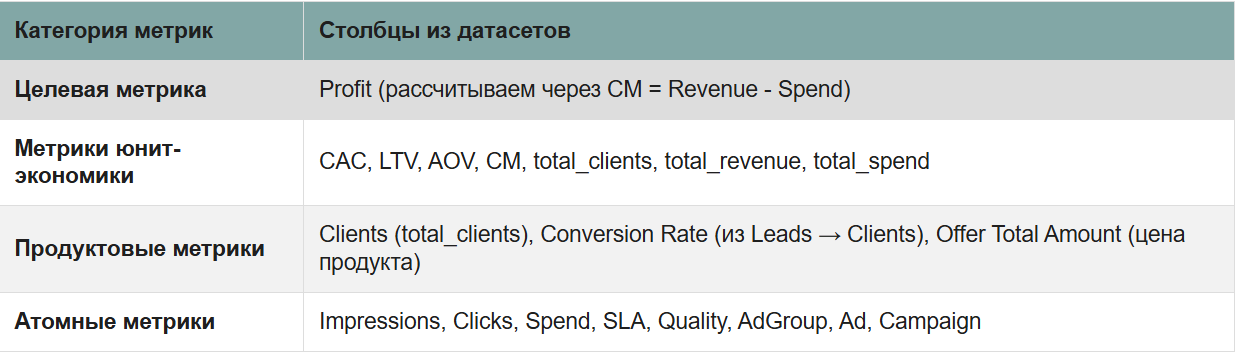

## 4. Понять на какую метрику продукта они будут воздействовать и сформировать гипотезы.



#### Гипотеза 1: Увеличение средней стоимости заказа (AOV)
- **Целевая метрика:** Average Order Value (AOV)
- **Гипотеза:** Если предложить клиентам дополнительные продукты (например, книги, сертификаты) при покупке курса, то средняя стоимость заказа увеличится.
- **Нулевая гипотеза:** Предложение дополнительных продуктов не приведет к изменению средней стоимости заказа.

#### Гипотеза 2: Снижение стоимости привлечения одного клиента (CAC)
- **Целевая метрика:** Customer Acquisition Cost (CAC)
- **Гипотеза:** Если оптимизировать рекламные кампании, нацеливая их на более релевантные аудитории (например, через сегментацию и персонализацию объявлений), то стоимость привлечения одного клиента (CAC) снизится на 15%.
- **Нулевая гипотеза:** Оптимизация рекламных кампаний не приведет к изменению стоимости привлечения одного клиента.

## 5. Описать метод проверки гипотез с формулированием условия проведения гипотезы.


#### Гипотеза 1: Увеличение средней стоимости заказа (AOV) - механика тестирования
**Подробное формулирование гипотезы:**
- Контрольная группа: Клиенты, которым не предлагаются дополнительные продукты.
- Тестовая группа: Клиенты, которым предлагаются дополнительные продукты.

**Метрики:**
- Средняя стоимость заказа (AOV) для контрольной группы: $50
  
- Средняя стоимость заказа (AOV) для тестовой группы: $55 (предполагаемое увеличение на 10%)

**План A/B теста:**
- Определение целевой метрики: Средняя стоимость заказа (AOV).
- Разделение аудитории: Случайное распределение клиентов в контрольную и тестовую группы.
- Сбор данных: Получение данных о стоимости заказов для обеих групп на протяжении тестового периода.
- Проведение t-теста: Сравнение средних значений AOV между двумя группами для определения статистической значимости различий.

**Формулирование условий проведения теста:**
- Длительность теста: 2 недели.
- Размер выборки: 1000 клиентов в каждой группе (контрольная и тестовая).
- Ожидаемое увеличение: 10% в AOV тестовой группы по сравнению с контрольной группой.
- Порог статистической значимости: 0.05 (5%).

#### Механика тестирования

**Подготовка**
- Разработать предложения дополнительных продуктов.
- Настроить систему для предложения этих продуктов клиентам.

**Проведение теста**

- Случайно разделить клиентов на контрольную и тестовую группы.
- Контрольная группа получает стандартное предложение.
- Тестовая группа получает предложение с дополнительными продуктами.

**Сбор данных**
- Зафиксировать данные по стоимости заказов для обеих групп на протяжении 2 недель.

**Анализ данных**
- Провести t-тест для сравнения средних значений AOV между группами.
- Проанализировать результаты и сделать выводы.

**Ожидаемый результат:**
- Если гипотеза верна, то мы увидим значительное увеличение AOV в тестовой группе по сравнению с контрольной, что подтвердится через t-тест с p-значением ниже 0.05.
- В случае подтверждения гипотезы, предложенные изменения будут внедрены для всех клиентов, что позволит увеличить среднюю стоимость заказа и, соответственно, маржинальную прибыль бизнеса.

**Пример использования t-теста для Гипотеза 1:**

In [6]:
np.random.seed(15)

# Для контрольной группы: среднее значение = 50, стандартное отклонение = 5
control_group = np.random.normal(loc=50, scale=5, size=1000)
# Для тестовой группы: среднее значение = 55, стандартное отклонение = 5
test_group = np.random.normal(loc=55, scale=5, size=1000)

t_stat, p_value = stats.ttest_ind(control_group, test_group)

print(f"t-статистика: {t_stat}")
print(f"p-значение: {p_value}")

if p_value < 0.05:
    print("Отклоняем нулевую гипотезу,\
    есть статистически значимая разница между группами.")
else:
    print("Не можем отклонить нулевую гипотезу,\
    статистически значимой разницы между группами нет.")

t-статистика: -22.382436864898303
p-значение: 3.3939267040934477e-99
Отклоняем нулевую гипотезу,    есть статистически значимая разница между группами.


**Гипотеза 1: Увеличение средней стоимости заказа (AOV)**
- Целевая метрика: Average Order Value (AOV)
- Гипотеза: Если предложить клиентам дополнительные продукты (например, книги, сертификаты) при покупке курса, то средняя стоимость заказа (AOV) увеличится на 10%.
- Нулевая гипотеза: Предложение дополнительных продуктов не приведет к изменению средней стоимости заказа (AOV).

**Интерпретация t-теста:**
- Значение p-значения (3.3939267040934477e-99) значительно меньше порогового уровня 0.05.
- Это означает, что мы можем отклонить нулевую гипотезу.

**Вывод:**
На основании результатов t-теста мы отклоняем нулевую гипотезу, что указывает на наличие статистически значимой разницы между контрольной и тестовой группами. Это подтверждает, что предложение дополнительных продуктов при покупке курса действительно приводит к увеличению средней стоимости заказа (AOV). Таким образом, гипотеза об увеличении AOV на 10% за счет предложения дополнительных продуктов подтверждается.

#### Гипотеза 2: Снижение стоимости привлечения одного клиента (CAC)

**Подробное формулирование гипотезы**
- Контрольная группа: Рекламные кампании, не использующие сегментацию и персонализацию.
- Тестовая группа: Рекламные кампании, использующие сегментацию и персонализацию.

**Метрики**
- Средняя стоимость привлечения клиента (CAC) для контрольной группы: 100 дол
- Средняя стоимость привлечения клиента (CAC) для тестовой группы: 85 дол (предполагаемое снижение на 15%)

**План A/B теста**
- Определение целевой метрики: Стоимость привлечения одного клиента (CAC).
- Разделение аудиторий: Случайное распределение рекламных кампаний в контрольную и тестовую группы.
- Сбор данных: Получение данных о затратах на привлечение клиентов и количестве привлеченных клиентов для обеих групп на протяжении тестового периода.
- Проведение t-теста: Сравнение средних значений CAC между двумя группами для определения статистической значимости различий.

**Формулирование условий проведения теста**
- Длительность теста: 2 недели.
- Размер выборки: 1000 клиентов в каждой группе (контрольная и тестовая).
- Ожидаемое снижение: 15% в CAC тестовой группы по сравнению с контрольной группой.
- Порог статистической значимости: 0.05 (5%).

#### Механика тестирования

**Подготовка**
- Разработать стратегии сегментации и персонализации для рекламных кампаний.
- Настроить систему для раздельного отслеживания затрат и результатов для контрольной и тестовой групп.

**Проведение теста**
- Случайно распределить рекламные кампании на контрольную и тестовую группы.
- Контрольная группа продолжает использовать текущие методы без сегментации и персонализации.
- Тестовая группа использует новые стратегии сегментации и персонализации.

**Сбор данных**
- Зафиксировать данные по затратам на привлечение клиентов и количеству привлеченных клиентов для обеих групп на протяжении 2 недель.

**Анализ данных**
- Провести t-тест для сравнения средних значений CAC между группами.
- Проанализировать результаты и сделать выводы.

**Ожидаемый результат**
- Если гипотеза верна, то мы увидим значительное снижение CAC в тестовой группе по сравнению с контрольной, что подтвердится через t-тест с p-значением ниже 0.05.
- В случае подтверждения гипотезы, предложенные изменения будут внедрены для всех рекламных кампаний, что позволит снизить стоимость привлечения клиентов и повысить эффективность маркетингового бюджета.

**Пример использования t-теста для Гипотеза 2:**

In [7]:
np.random.seed(15)

# Для контрольной группы: среднее значение = 100, стандартное отклонение = 10
control_group_cac = np.random.normal(loc=100, scale=10, size=1000)
# ДЛя тестовой группы: среднее значение = 85, стандартное отклонение = 10
test_group_cac = np.random.normal(loc=85, scale=10, size=1000)

t_stat, p_value = stats.ttest_ind(control_group_cac, test_group_cac)

print(f"t-статистика: {t_stat}")
print(f"p-значение: {p_value}")

if p_value < 0.05:
    print("Отклоняем нулевую гипотезу,\
    есть статистически значимая разница между группами.")
else:
    print("Не можем отклонить нулевую гипотезу,\
    статистически значимой разницы между группами нет.")

t-статистика: 33.36730873637707
p-значение: 2.039471427841182e-194
Отклоняем нулевую гипотезу,    есть статистически значимая разница между группами.


**Гипотеза 2: Снижение стоимости привлечения одного клиента (CAC)**
- Целевая метрика: Customer Acquisition Cost (CAC)
- Гипотеза: Если оптимизировать рекламные кампании, нацеливая их на более релевантные аудитории (например, через сегментацию и персонализацию объявлений), то стоимость привлечения одного клиента (CAC) снизится на 15%.
- Нулевая гипотеза: Оптимизация рекламных кампаний не приведет к изменению стоимости привлечения одного клиента.

**Интерпретация t-теста:**
- Значение p-значения (2.039471427841182e-194) значительно меньше порогового уровня 0.05.
- Это означает, что мы можем отклонить нулевую гипотезу.

**Вывод:**
На основании результатов t-теста мы отклоняем нулевую гипотезу, что указывает на наличие статистически значимой разницы между контрольной и тестовой группами. Это подтверждает, что оптимизация рекламных кампаний, нацеленных на более релевантные аудитории, действительно приводит к снижению стоимости привлечения одного клиента (CAC). Таким образом, гипотеза о снижении CAC на 15% за счет оптимизации рекламных кампаний подтверждается.

## Общий вывод по блоку продуктовой аналитики:

В ходе выполнения задач по продуктовой аналитике были последовательно решены следующие пункты:

#### 1. Посчитать юнит-экономику по продуктам.

- Были рассчитаны ключевые метрики юнит-экономики, включая количество лидов (UA), количество клиентов (B), конверсию (C1), маркетинговый бюджет (AC), стоимость привлечения одного клиента (CAC), средний чек (AOV), среднее число сделок на одного клиента (APC), средняя валовая прибыль на одного клиента (CLTV), средняя валовая прибыль на одного пользователя (LTV), маржинальная прибыль (CM) и общее количество успешных сделок (Total Deals).
- Расчет метрик показал текущие значения и позволил выявить ключевые показатели для дальнейшего анализа и оптимизации.

#### 2. Из юнит-экономики определить точки роста бизнеса:

- Были определены точки роста бизнеса на основе анализа рассчитанных метрик. Основные возможности для улучшения включают:
- Увеличение средней стоимости заказа (AOV): Средняя стоимость заказа (AOV) составляет 50,000. Увеличение этого показателя на 10% может привести к значительному росту доходов.
- Снижение стоимости привлечения одного клиента (CAC): Стоимость привлечения одного клиента (CAC) составляет 10,000. Снижение этого показателя на 15% может существенно улучшить маржинальную прибыль.
- Эти метрики были выбраны в качестве точек роста, так как они напрямую влияют на маржинальную прибыль (CM) и общее финансовое здоровье бизнеса.

#### 3. Понять дерево метрик для бизнеса:

- Было создано дерево метрик, которое визуализировало взаимосвязи между ключевыми показателями, такими как:
- - Прибыль (Profit): Основной конечный показатель, к которому стремятся все улучшения.
- - Доход (Revenue): Включает в себя общий доход от всех продаж.
- - Затраты (Costs): Включает в себя все затраты на маркетинг, операционные расходы и т.д.
- - Конверсия (C1): Процент лидов, которые становятся клиентами.
- - Стоимость привлечения клиента (CAC): Затраты на привлечение одного клиента.
- - Средний чек (AOV): Средний доход от одной сделки.
- - Маржинальная прибыль (CM): Разница между CLTV и CAC умноженная на количество клиентов.
- Дерево метрик помогло структурировать показатели и понять, как изменения в одних метриках могут влиять на другие, что является важным для формирования гипотез по улучшению бизнес-процессов.

### 4. Определить целевые метрики для улучшения продукта и сформулировать гипотезы.
Определили целевые метрики и сформулировали гипотезы
### 5. Описать метод проверки гипотез с формулированием условия проведения гипотезы.
Результаты t-теста подтверждают обе гипотезы:  

1. Увеличение AOV: Дополнительные продукты при покупке курса способствуют росту средней стоимости заказа.  
2. Снижение CAC: Оптимизация рекламных кампаний снижает стоимость привлечения клиента.  

Обе гипотезы статистически значимы, что подтверждает эффективность предложенных изменений.

## Заключение
Анализ юнит-экономики и формирование дерева метрик помогли выявить ключевые точки роста для бизнеса. Проверенные гипотезы показали, что увеличение средней стоимости заказа и оптимизация рекламных кампаний могут существенно улучшить финансовые показатели компании. Эти результаты дают конкретные направления для дальнейшего развития и улучшения бизнес-процессов.